# Testing data analysis scripts of a run

In case you only have the h5 files and not the .json

In [1]:
%matplotlib notebook
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from escape.parse import swissfel
import h5py
from jungfrau_utils import apply_gain_pede, apply_geometry
h5py.enable_ipython_completer()
import time
import sys

In [2]:
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *

In [54]:
n_shots = 2000
run = '0005_jet10um_RT'
path = '/sf/bernina/data/p17743/res/scan_info/'
# load data                                                                         
file_path = '%srun%s.json'%(path,run)
print('-- Loading data:%s'%file_path)
data = swissfel.parseScanEco_v01(file_path,createEscArrays=True,memlimit_mD_MB=50)
jf7 = data['JF07T32V01'] # JungFrau data                                            
total_shots = jf7.data.shape[jf7.eventDim]
if (n_shots>total_shots) or (n_shots==0):
    n_shots = total_shots
print('-- JungFrau 16 Mpix detector contains %d shots - analyzing %d shots' % (total_shots, n_shots))

-- Loading data:/sf/bernina/data/p17743/res/scan_info/run0005_jet10um_RT.json
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SARES20-PROF142-M3:FPICTURE in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 1
Found empty dataset in SARES20-PROF142-M3:FPICTURE in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 2
Found empty dataset in SARES20-PROF142-M3:FPICTURE in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in 

In [42]:
print('-- Loading corrections')
with h5py.File('/sf/bernina/config/jungfrau/gainMaps/JF07T32V01/gains.h5','r') as f:
    gains = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/waterJet_tests/JFpedestal/pedestal_20190125_1507.JF07T32V01.res.h5','r') as f:
    pede = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/JF_pedestals/pedestal_20190115_1551.JF07T32V01.res.h5','r') as f:
    noise = f['gainsRMS'].value
    mask = f['pixel_mask'].value

-- Loading corrections


In [55]:
t1 = time.time()
icorr = apply_gain_pede(jf7.data[0].compute(),G=gains, P=pede, pixel_mask=mask)
icorr_geom = apply_geometry(icorr,'JF07T32V01')
mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
icorr_geom[mask_geom] = 0 #np.nan
avg_img_even = np.zeros_like(icorr_geom)
avg_img_odd = np.zeros_like(icorr_geom)
mask_inv = np.logical_not(mask_geom) #inversed: 0 masked, 1 not masked  
iq_threshold = 16.
hits_even = 0
hits_odd = 0

# initialise for angular integration                                        
rad_dist = radial_distances(icorr_geom)
ra = RadialAverager(rad_dist, mask_inv)
r  = ra.bin_centers
iq = ra(icorr_geom)
iqs = np.zeros((n_shots, iq.shape[0]))
iqs[0] = iq
print('s.%i, %.1f Hz: %.2f photon/pix' % (1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))

for i in range(1,n_shots):
    t1 = time.time()
    icorr = apply_gain_pede(jf7.data[i].compute(),G=gains, P=pede, pixel_mask=mask)
    icorr_geom = apply_geometry(icorr,'JF07T32V01')
    icorr_geom[mask_geom] = 0
    iq = ra(icorr_geom)
    iqs[i] = iq
    if iq[5:80].mean() > iq_threshold:
        if (i % 2) == 0:
            avg_img_even += icorr_geom
            hits_even += 1
            print('s.%i, %.1f Hz: %.2f photon/pix: EVEN HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
        else:
            avg_img_odd += icorr_geom
            hits_odd += 1
            print('s.%i, %.1f Hz: %.2f photon/pix: ODD HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
    else:
        print('s.%i, %.1f Hz: %.2f photon/pix' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
avg_img_even /= hits_even
avg_img_odd /= hits_odd
print('-- DONE! even: %d hits, odd: %d hits, total hitrate: %.1f%%' % (hits_even, hits_odd, 100*(hits_even+hits_odd)/n_shots))

s.1, 0.7 Hz: 0.73 photon/pix
s.2, 2.0 Hz: 2.00 photon/pix: ODD HIT
s.3, 2.1 Hz: 0.73 photon/pix
s.4, 2.2 Hz: 0.48 photon/pix
s.5, 2.3 Hz: 0.58 photon/pix
s.6, 2.2 Hz: 0.48 photon/pix
s.7, 2.3 Hz: 0.50 photon/pix
s.8, 2.2 Hz: 0.50 photon/pix
s.9, 2.3 Hz: 0.58 photon/pix
s.10, 2.3 Hz: 0.71 photon/pix
s.11, 2.2 Hz: 0.71 photon/pix
s.12, 2.2 Hz: 1.31 photon/pix: ODD HIT
s.13, 2.2 Hz: 0.63 photon/pix
s.14, 2.2 Hz: 0.67 photon/pix
s.15, 2.3 Hz: 0.67 photon/pix
s.16, 2.2 Hz: 0.73 photon/pix
s.17, 2.2 Hz: 1.59 photon/pix: EVEN HIT
s.18, 2.2 Hz: 1.30 photon/pix: ODD HIT
s.19, 2.3 Hz: 0.72 photon/pix
s.20, 2.2 Hz: 1.43 photon/pix: ODD HIT
s.21, 2.2 Hz: 0.70 photon/pix
s.22, 2.2 Hz: 0.70 photon/pix
s.23, 2.3 Hz: 0.60 photon/pix
s.24, 2.2 Hz: 0.76 photon/pix
s.25, 2.3 Hz: 0.75 photon/pix
s.26, 2.2 Hz: 0.73 photon/pix
s.27, 2.2 Hz: 2.04 photon/pix: EVEN HIT
s.28, 2.3 Hz: 0.72 photon/pix
s.29, 2.2 Hz: 0.66 photon/pix
s.30, 2.2 Hz: 1.85 photon/pix: ODD HIT
s.31, 2.2 Hz: 1.94 photon/pix: EVEN HIT
s.32

s.259, 2.2 Hz: 0.73 photon/pix
s.260, 2.3 Hz: 0.67 photon/pix
s.261, 2.3 Hz: 0.70 photon/pix
s.262, 2.2 Hz: 1.37 photon/pix: ODD HIT
s.263, 2.2 Hz: 0.64 photon/pix
s.264, 2.3 Hz: 0.59 photon/pix
s.265, 2.3 Hz: 0.68 photon/pix
s.266, 2.3 Hz: 0.56 photon/pix
s.267, 2.3 Hz: 0.67 photon/pix
s.268, 2.3 Hz: 0.56 photon/pix
s.269, 2.2 Hz: 1.54 photon/pix: EVEN HIT
s.270, 2.3 Hz: 0.66 photon/pix
s.271, 2.2 Hz: 0.68 photon/pix
s.272, 2.2 Hz: 1.11 photon/pix: ODD HIT
s.273, 2.2 Hz: 0.68 photon/pix
s.274, 2.3 Hz: 0.66 photon/pix
s.275, 2.2 Hz: 2.09 photon/pix: EVEN HIT
s.276, 2.3 Hz: 0.71 photon/pix
s.277, 2.2 Hz: 0.72 photon/pix
s.278, 2.2 Hz: 0.63 photon/pix
s.279, 2.2 Hz: 0.59 photon/pix
s.280, 2.3 Hz: -0.00 photon/pix
s.281, 2.2 Hz: 0.47 photon/pix
s.282, 2.2 Hz: 0.40 photon/pix
s.283, 2.2 Hz: 0.37 photon/pix
s.284, 2.2 Hz: 0.51 photon/pix
s.285, 2.2 Hz: 0.59 photon/pix
s.286, 2.2 Hz: 0.66 photon/pix
s.287, 2.3 Hz: 0.72 photon/pix
s.288, 2.3 Hz: 0.72 photon/pix
s.289, 2.2 Hz: 0.68 photon/pix


s.513, 2.3 Hz: 0.74 photon/pix
s.514, 2.3 Hz: 0.73 photon/pix
s.515, 2.3 Hz: 0.54 photon/pix
s.516, 2.3 Hz: 0.73 photon/pix
s.517, 2.3 Hz: 0.39 photon/pix
s.518, 2.2 Hz: 0.50 photon/pix
s.519, 2.3 Hz: 0.62 photon/pix
s.520, 2.2 Hz: 0.65 photon/pix
s.521, 2.3 Hz: 0.66 photon/pix
s.522, 2.3 Hz: 0.66 photon/pix
s.523, 2.2 Hz: 2.28 photon/pix: EVEN HIT
s.524, 2.3 Hz: 0.51 photon/pix
s.525, 2.3 Hz: 0.61 photon/pix
s.526, 2.3 Hz: 0.63 photon/pix
s.527, 2.3 Hz: 0.57 photon/pix
s.528, 2.3 Hz: 0.61 photon/pix
s.529, 2.2 Hz: 0.62 photon/pix
s.530, 2.2 Hz: 0.64 photon/pix
s.531, 2.2 Hz: 0.68 photon/pix
s.532, 2.3 Hz: 0.67 photon/pix
s.533, 2.3 Hz: 0.64 photon/pix
s.534, 2.3 Hz: 0.75 photon/pix
s.535, 2.3 Hz: 0.74 photon/pix
s.536, 2.3 Hz: 0.62 photon/pix
s.537, 2.2 Hz: 0.69 photon/pix
s.538, 2.2 Hz: 0.66 photon/pix
s.539, 2.1 Hz: 1.67 photon/pix: EVEN HIT
s.540, 2.2 Hz: 0.55 photon/pix
s.541, 2.2 Hz: 0.70 photon/pix
s.542, 2.1 Hz: 1.89 photon/pix: ODD HIT
s.543, 2.3 Hz: 0.50 photon/pix
s.544, 2.3

s.770, 2.2 Hz: 1.45 photon/pix: ODD HIT
s.771, 2.3 Hz: 0.71 photon/pix
s.772, 2.3 Hz: 0.61 photon/pix
s.773, 2.2 Hz: 1.37 photon/pix: EVEN HIT
s.774, 2.3 Hz: 0.64 photon/pix
s.775, 2.2 Hz: 0.72 photon/pix
s.776, 2.1 Hz: 1.58 photon/pix: ODD HIT
s.777, 2.2 Hz: 0.61 photon/pix
s.778, 2.3 Hz: 0.62 photon/pix
s.779, 2.3 Hz: 0.57 photon/pix
s.780, 2.3 Hz: 0.61 photon/pix
s.781, 2.3 Hz: 0.56 photon/pix
s.782, 2.2 Hz: 0.85 photon/pix
s.783, 2.2 Hz: 0.59 photon/pix
s.784, 2.2 Hz: 0.91 photon/pix
s.785, 2.2 Hz: 0.65 photon/pix
s.786, 2.2 Hz: 0.81 photon/pix
s.787, 2.2 Hz: 0.53 photon/pix
s.788, 2.2 Hz: 1.45 photon/pix: ODD HIT
s.789, 2.2 Hz: 0.59 photon/pix
s.790, 2.1 Hz: 0.45 photon/pix
s.791, 2.2 Hz: 0.53 photon/pix
s.792, 2.2 Hz: 0.55 photon/pix
s.793, 2.2 Hz: 0.41 photon/pix
s.794, 2.2 Hz: 0.53 photon/pix
s.795, 2.2 Hz: 0.63 photon/pix
s.796, 2.2 Hz: 0.56 photon/pix
s.797, 2.2 Hz: 0.64 photon/pix
s.798, 2.2 Hz: 0.64 photon/pix
s.799, 2.2 Hz: 0.58 photon/pix
s.800, 2.2 Hz: 0.61 photon/pix
s.

s.1024, 2.2 Hz: 0.55 photon/pix
s.1025, 2.3 Hz: 0.84 photon/pix
s.1026, 2.3 Hz: 0.66 photon/pix
s.1027, 2.2 Hz: 0.60 photon/pix
s.1028, 2.4 Hz: 0.59 photon/pix
s.1029, 2.3 Hz: 0.49 photon/pix
s.1030, 2.3 Hz: 0.59 photon/pix
s.1031, 2.3 Hz: 0.59 photon/pix
s.1032, 2.3 Hz: 0.69 photon/pix
s.1033, 2.3 Hz: 0.57 photon/pix
s.1034, 2.2 Hz: 0.68 photon/pix
s.1035, 2.1 Hz: 1.70 photon/pix: EVEN HIT
s.1036, 2.2 Hz: 0.64 photon/pix
s.1037, 2.2 Hz: 1.27 photon/pix: EVEN HIT
s.1038, 2.2 Hz: 0.74 photon/pix
s.1039, 2.2 Hz: 0.63 photon/pix
s.1040, 2.1 Hz: 0.53 photon/pix
s.1041, 2.2 Hz: 0.44 photon/pix
s.1042, 2.2 Hz: 0.64 photon/pix
s.1043, 2.2 Hz: 0.66 photon/pix
s.1044, 2.3 Hz: 0.55 photon/pix
s.1045, 2.2 Hz: 1.88 photon/pix: EVEN HIT
s.1046, 2.2 Hz: 0.57 photon/pix
s.1047, 2.2 Hz: 1.18 photon/pix: EVEN HIT
s.1048, 2.2 Hz: 0.71 photon/pix
s.1049, 2.2 Hz: 0.68 photon/pix
s.1050, 2.2 Hz: 0.54 photon/pix
s.1051, 2.2 Hz: 0.75 photon/pix
s.1052, 2.3 Hz: 0.71 photon/pix
s.1053, 2.4 Hz: 0.68 photon/pix


s.1271, 2.4 Hz: 0.65 photon/pix
s.1272, 2.4 Hz: 0.66 photon/pix
s.1273, 2.4 Hz: 0.64 photon/pix
s.1274, 2.4 Hz: 0.61 photon/pix
s.1275, 2.4 Hz: 0.62 photon/pix
s.1276, 2.4 Hz: 0.55 photon/pix
s.1277, 2.3 Hz: 0.65 photon/pix
s.1278, 2.3 Hz: 0.70 photon/pix
s.1279, 2.4 Hz: 0.56 photon/pix
s.1280, 2.4 Hz: 0.63 photon/pix
s.1281, 2.4 Hz: 0.58 photon/pix
s.1282, 2.4 Hz: 0.61 photon/pix
s.1283, 2.3 Hz: 0.61 photon/pix
s.1284, 2.4 Hz: 0.61 photon/pix
s.1285, 2.3 Hz: 1.71 photon/pix: EVEN HIT
s.1286, 2.4 Hz: 0.70 photon/pix
s.1287, 2.4 Hz: 0.65 photon/pix
s.1288, 2.3 Hz: 0.65 photon/pix
s.1289, 2.4 Hz: 0.72 photon/pix
s.1290, 2.4 Hz: 0.82 photon/pix
s.1291, 2.4 Hz: 0.56 photon/pix
s.1292, 2.3 Hz: 1.63 photon/pix: ODD HIT
s.1293, 2.3 Hz: 0.67 photon/pix
s.1294, 2.4 Hz: 2.08 photon/pix: ODD HIT
s.1295, 2.4 Hz: 0.69 photon/pix
s.1296, 2.3 Hz: 1.40 photon/pix: ODD HIT
s.1297, 2.5 Hz: 0.50 photon/pix
s.1298, 2.4 Hz: 1.42 photon/pix: ODD HIT
s.1299, 2.4 Hz: 0.57 photon/pix
s.1300, 2.5 Hz: 0.64 photo

s.1520, 2.4 Hz: 0.65 photon/pix
s.1521, 2.4 Hz: 0.68 photon/pix
s.1522, 2.4 Hz: 0.56 photon/pix
s.1523, 2.5 Hz: 0.72 photon/pix
s.1524, 2.5 Hz: 0.66 photon/pix
s.1525, 2.5 Hz: 0.73 photon/pix
s.1526, 2.3 Hz: 0.72 photon/pix
s.1527, 2.5 Hz: 0.69 photon/pix
s.1528, 2.4 Hz: 1.01 photon/pix
s.1529, 2.5 Hz: 0.73 photon/pix
s.1530, 2.5 Hz: 0.54 photon/pix
s.1531, 2.5 Hz: 0.64 photon/pix
s.1532, 2.5 Hz: 0.66 photon/pix
s.1533, 2.4 Hz: 0.68 photon/pix
s.1534, 2.5 Hz: 0.70 photon/pix
s.1535, 2.4 Hz: 0.61 photon/pix
s.1536, 2.4 Hz: 0.67 photon/pix
s.1537, 2.4 Hz: 0.63 photon/pix
s.1538, 2.4 Hz: 0.66 photon/pix
s.1539, 2.4 Hz: 0.55 photon/pix
s.1540, 2.4 Hz: 0.51 photon/pix
s.1541, 2.3 Hz: 1.17 photon/pix: EVEN HIT
s.1542, 2.4 Hz: 0.62 photon/pix
s.1543, 2.4 Hz: 0.60 photon/pix
s.1544, 2.5 Hz: 0.61 photon/pix
s.1545, 2.5 Hz: 0.70 photon/pix
s.1546, 2.4 Hz: 0.60 photon/pix
s.1547, 2.4 Hz: 0.62 photon/pix
s.1548, 2.4 Hz: 0.68 photon/pix
s.1549, 2.5 Hz: 0.63 photon/pix
s.1550, 2.5 Hz: 0.57 photon/pi

s.1771, 2.4 Hz: 0.65 photon/pix
s.1772, 2.4 Hz: 1.64 photon/pix: ODD HIT
s.1773, 2.5 Hz: 0.66 photon/pix
s.1774, 2.5 Hz: 0.63 photon/pix
s.1775, 2.4 Hz: 0.57 photon/pix
s.1776, 2.5 Hz: 0.47 photon/pix
s.1777, 2.5 Hz: 0.57 photon/pix
s.1778, 2.5 Hz: 0.54 photon/pix
s.1779, 2.5 Hz: 0.56 photon/pix
s.1780, 2.4 Hz: 0.68 photon/pix
s.1781, 2.4 Hz: 1.62 photon/pix: EVEN HIT
s.1782, 2.4 Hz: 0.69 photon/pix
s.1783, 2.3 Hz: 0.65 photon/pix
s.1784, 2.4 Hz: 0.65 photon/pix
s.1785, 2.4 Hz: 0.77 photon/pix
s.1786, 2.3 Hz: 1.90 photon/pix: ODD HIT
s.1787, 2.4 Hz: 0.72 photon/pix
s.1788, 2.4 Hz: 0.65 photon/pix
s.1789, 2.4 Hz: 0.56 photon/pix
s.1790, 2.4 Hz: 0.99 photon/pix
s.1791, 2.3 Hz: 1.35 photon/pix: EVEN HIT
s.1792, 2.4 Hz: 0.70 photon/pix
s.1793, 2.3 Hz: 1.23 photon/pix: EVEN HIT
s.1794, 2.4 Hz: 0.39 photon/pix
s.1795, 2.4 Hz: 0.40 photon/pix
s.1796, 2.4 Hz: 0.42 photon/pix
s.1797, 2.4 Hz: 0.79 photon/pix
s.1798, 2.4 Hz: 0.67 photon/pix
s.1799, 2.4 Hz: 0.63 photon/pix
s.1800, 2.3 Hz: 1.70 pho

<IPython.core.display.Javascript object>


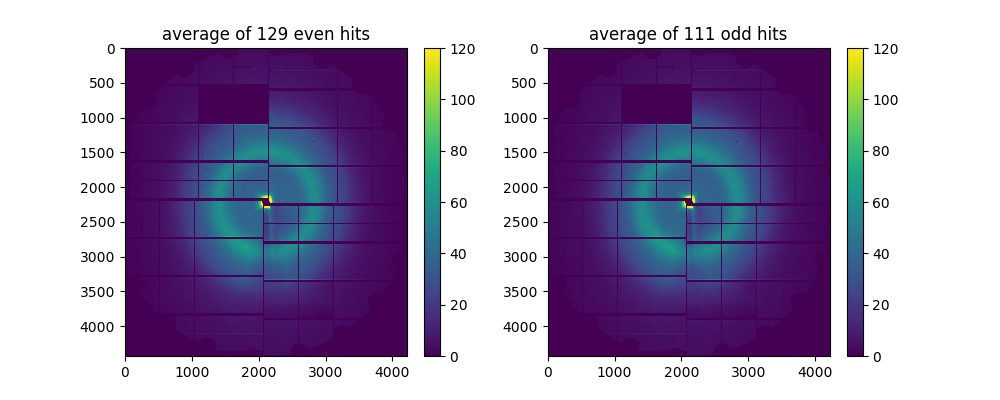

In [56]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('average of %d even hits' % hits_even)
plt.imshow(avg_img_even,aspect='auto',clim=[0,120])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('average of %d odd hits' % hits_odd)
plt.imshow(avg_img_odd,aspect='auto',clim=[0,120])
plt.colorbar()

plt.savefig('run%s_2d_hits_even_vs_odd.png' % run)
plt.show()

In [57]:
iq_metric = iqs[:,5:80].mean(axis=1)
bi,bf,db = iq_metric.min(),iq_metric.max(),.5
bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(iq_metric,bins=bins)
bin_centers = np.array([(bins[j]+bins[j+1])/2. for j in range(len(bins)-1)])

<IPython.core.display.Javascript object>


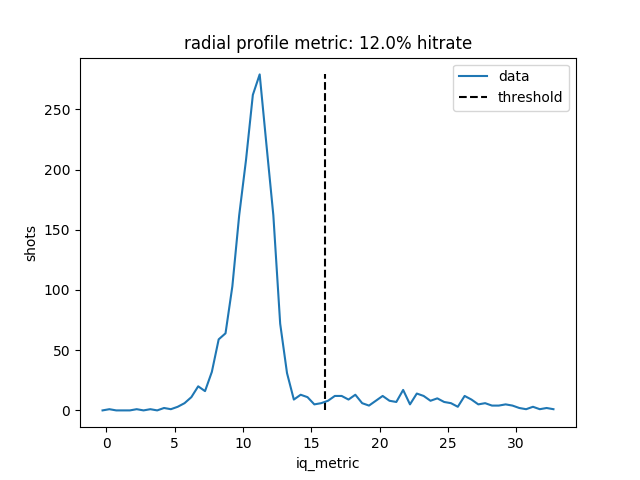

In [58]:
#iq_threshold = 4*4
plt.figure()
plt.title('radial profile metric: %.1f%% hitrate' % (100*(iq_metric > iq_threshold).sum()/n_shots))
plt.plot(bin_centers, hy, label='data')
plt.ylabel('shots')
plt.xlabel('iq_metric')
plt.vlines(iq_threshold,0,hy.max(),color='k',linestyles='dashed',label='threshold')
plt.legend()
plt.savefig('run%s_radial_profile_hist.png' % run)
plt.show()

In [62]:
q = q_scale(r, detector_distance=0.127)
iqs_even = iqs[::2]
iqs_odd = iqs[1::2]
iq_avg_even = iqs_even[iq_metric[::2] > iq_threshold].mean(axis=0)
iq_avg_odd = iqs_odd[iq_metric[1::2] > iq_threshold].mean(axis=0)

<IPython.core.display.Javascript object>


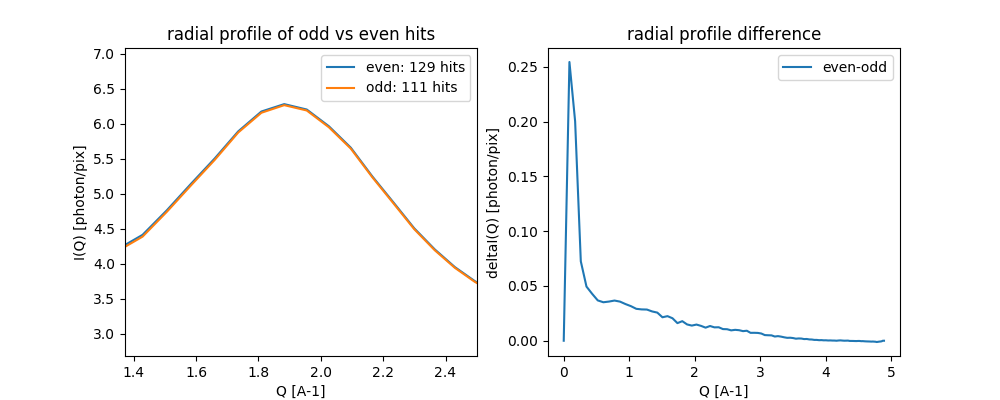

In [63]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/9.5, label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/9.5, label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
plt.plot(q, (iq_avg_even-iq_avg_odd)/9.5, label='even-odd')
plt.ylabel('deltaI(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

#plt.savefig('run%s_radial_profile_even_vs_odd.png' % run)
plt.show()

<IPython.core.display.Javascript object>


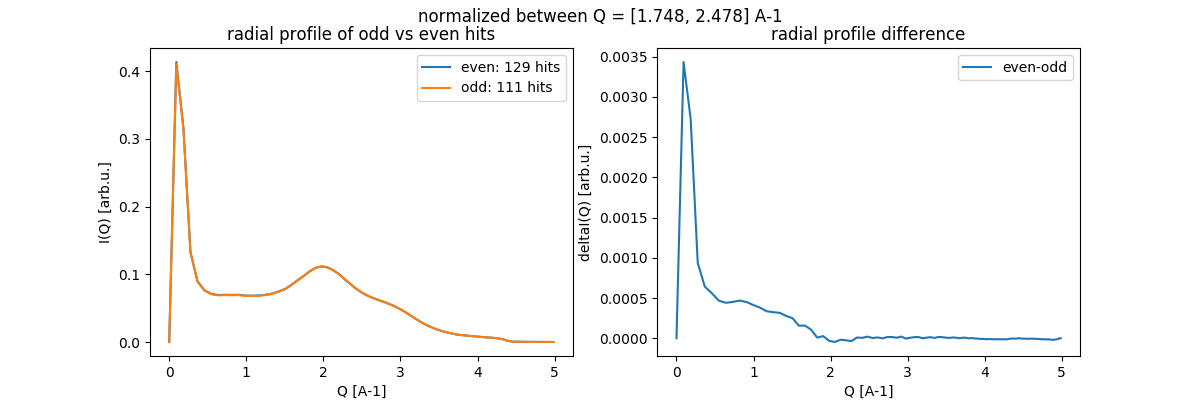

In [61]:
plt.figure(figsize=[12,4])
plt.suptitle('normalized between Q = [%.03f, %.03f] A-1' % (q[20], q[30]))
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/iq_avg_even[20:30].sum(), label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/iq_avg_odd[20:30].sum(), label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
plt.plot(q, iq_avg_even/iq_avg_even[20:30].sum()-iq_avg_odd/iq_avg_odd[20:30].sum(), label='even-odd')
plt.ylabel('deltaI(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.legend()
#plt.tight_layout()

plt.savefig('run%s_radial_profile_even_vs_odd_normalized.png' % run)
plt.show()